# Predicting the MVP

In this project, I will look at the csv file player_mvp_stats.csv and try to predict the MVP using **Ridge regression and Random Forest regression**. First, I will clean the data. Then, I will define the ridge regression model and train it and then test it using an **error metric which measures how many tries it took the algo. to get the top 5 MVPs**. After that, I will create a **back testing** function that tests the model for all the previous years. Finally I will add some new predictors to improve the model and apply Random Forest Rgression to improve the predictions. **The algorithm correctly predicts the top 5 MVPs 77% of the time**.

In [162]:
import pandas as pd

#### Loading and Cleaning the data.

In [163]:
stats = pd.read_csv("player_mvp_stats.csv")
stats.head()

,Unnamed: 0,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,0,A.C. Green,PF,22.0,LAL,82.0,1.0,18.8,2.5,4.7,...,0.0,0.000,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84
1,1,Byron Scott,SG,24.0,LAL,76.0,62.0,28.8,6.7,13.0,...,0.0,0.000,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84
2,2,James Worthy,SF,24.0,LAL,75.0,73.0,32.7,8.4,14.5,...,780.0,0.009,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84
3,3,Jerome Henderson,C,26.0,LAL,1.0,0.0,3.0,2.0,3.0,...,0.0,0.000,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84
4,4,Kareem Abdul-Jabbar,C,38.0,LAL,79.0,79.0,33.3,9.6,16.9,...,780.0,0.173,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84


In [164]:
del stats["Unnamed: 0"]

In [165]:
# checking for null values.
pd.isnull(stats).sum()

Player        0
Pos           1
Age           1
Tm            1
G             1
GS          544
MP            1
FG            1
FGA           1
FG%          64
3P            1
3PA           1
3P%        2740
2P            1
2PA           1
2P%         107
eFG%         64
FT            1
FTA           1
FT%         585
ORB           1
DRB           1
TRB           1
AST           1
STL           1
BLK           1
TOV           1
PF            1
PTS           1
Year          0
Pts Won       0
Pts Max       0
Share         0
Team        151
W           151
L           151
W/L%        151
GB          151
PS/G        151
PA/G        151
SRS         151
dtype: int64

In [166]:
# checking why there would be null values
stats[pd.isnull(stats["FT%"])][["Player", "FTA"]]

,Player,FTA
3,Jerome Henderson,0.0
144,John Coker,0.0
159,Jason Sasser,0.0
170,Adrian Caldwell,0.0
186,Bruno Šundov,0.0
...,...,...
18075,Mark McNamara,0.0
18103,Luke Zeller,0.0
18156,Myron Brown,0.0
18178,Malcolm Lee,0.0


In [167]:
# filling with 0. This is not exactly correct.
# But works well for our purposes.
stats = stats.fillna(0)

In [168]:
# checking that the changes took effect
pd.isnull(stats).sum()

Player     0
Pos        0
Age        0
Tm         0
G          0
GS         0
MP         0
FG         0
FGA        0
FG%        0
3P         0
3PA        0
3P%        0
2P         0
2PA        0
2P%        0
eFG%       0
FT         0
FTA        0
FT%        0
ORB        0
DRB        0
TRB        0
AST        0
STL        0
BLK        0
TOV        0
PF         0
PTS        0
Year       0
Pts Won    0
Pts Max    0
Share      0
Team       0
W          0
L          0
W/L%       0
GB         0
PS/G       0
PA/G       0
SRS        0
dtype: int64

In [169]:
stats.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Pts Won', 'Pts Max', 'Share', 'Team', 'W', 'L', 'W/L%', 'GB', 'PS/G',
       'PA/G', 'SRS'],
      dtype='object')

In [170]:
# only using numeric and not the mvp votes.
predictors = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
        'W', 'L', 'W/L%', 'GB', 'PS/G',
       'PA/G', 'SRS']

In [171]:
stats["Year"].unique()

array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2017, 2010, 2011, 2012,
       2013, 2014, 2015, 2008, 2009, 2016, 2018, 2019, 2020, 2021, 2022,
       2004, 2005, 2006, 2007, 1980, 1981, 1982, 1983, 1984, 1985])

In [172]:
train = stats[stats["Year"] < 2022]

In [173]:
test = stats[stats["Year"] == 2022]

In [174]:
train.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,22.0,LAL,82.0,1.0,18.8,2.5,4.7,0.539,...,0.0,0.000,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84
1,Byron Scott,SG,24.0,LAL,76.0,62.0,28.8,6.7,13.0,0.513,...,0.0,0.000,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84
2,James Worthy,SF,24.0,LAL,75.0,73.0,32.7,8.4,14.5,0.579,...,780.0,0.009,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84
3,Jerome Henderson,C,26.0,LAL,1.0,0.0,3.0,2.0,3.0,0.667,...,0.0,0.000,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84
4,Kareem Abdul-Jabbar,C,38.0,LAL,79.0,79.0,33.3,9.6,16.9,0.564,...,780.0,0.173,Los Angeles Lakers,62.0,20.0,0.756,0.0,117.3,109.5,6.84


In [175]:
test.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
715,Aaron Gordon,PF,26.0,DEN,75.0,75.0,31.7,5.8,11.1,0.520,...,0.0,0.0,Denver Nuggets,48.0,34.0,0.585,1.0,112.7,110.4,2.16
716,Austin Rivers,SG,29.0,DEN,67.0,18.0,22.1,2.2,5.2,0.417,...,0.0,0.0,Denver Nuggets,48.0,34.0,0.585,1.0,112.7,110.4,2.16
717,Bol Bol,PF,22.0,DEN,14.0,0.0,5.8,1.1,1.9,0.556,...,0.0,0.0,Denver Nuggets,48.0,34.0,0.585,1.0,112.7,110.4,2.16
718,Bones Hyland,SG,21.0,DEN,69.0,4.0,19.0,3.3,8.3,0.403,...,0.0,0.0,Denver Nuggets,48.0,34.0,0.585,1.0,112.7,110.4,2.16
719,Bryn Forbes,SG,28.0,DEN,75.0,2.0,17.1,3.1,7.2,0.429,...,0.0,0.0,Denver Nuggets,48.0,34.0,0.585,1.0,112.7,110.4,2.16


### Baseline Model

Creating a baseline Ridge regression model.

In [176]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha = 0.1)

In [177]:
reg.fit(train[predictors], train["Share"])

Ridge(alpha=0.1)

In [178]:
predictions = reg.predict(test[predictors])

In [179]:
predictions = pd.DataFrame(predictions, columns=["predictions"], index = test.index)

In [180]:
predictions

,predictions
715,0.011335
716,-0.031913
717,-0.004785
718,0.018834
719,-0.007124
...,...
15389,-0.015732
15390,-0.009122
15391,0.007408
15392,0.006101


In [181]:
combination = pd.concat([test[["Player", "Share"]], predictions], axis = 1)

In [182]:
combination

,Player,Share,predictions
715,Aaron Gordon,0.0,0.011335
716,Austin Rivers,0.0,-0.031913
717,Bol Bol,0.0,-0.004785
718,Bones Hyland,0.0,0.018834
719,Bryn Forbes,0.0,-0.007124
...,...,...,...
15389,Micah Potter,0.0,-0.015732
15390,Rodney McGruder,0.0,-0.009122
15391,Saben Lee,0.0,0.007408
15392,Saddiq Bey,0.0,0.006101


In [183]:
combination.sort_values("Share", ascending=False).head(10)

,Player,Share,predictions
730,Nikola Jokić,0.875,0.205077
904,Joel Embiid,0.706,0.199724
14472,Giannis Antetokounmpo,0.595,0.219371
974,Devin Booker,0.216,0.093413
14263,Luka Dončić,0.146,0.163396
1246,Jayson Tatum,0.043,0.100722
15107,Ja Morant,0.010,0.118509
7628,Stephen Curry,0.004,0.101065
972,Chris Paul,0.002,0.086199
9677,LeBron James,0.001,0.159685


In [184]:
from sklearn.metrics import mean_squared_error

mean_squared_error(combination["Share"], combination["predictions"])

0.0022497427914943903

### Combining ranks and putting them into one dataframe.

In [185]:
combination = combination.sort_values("Share", ascending=False)
combination["Rank"] = list(range(1,combination.shape[0]+1))
combination.head(10)

,Player,Share,predictions,Rank
730,Nikola Jokić,0.875,0.205077,1
904,Joel Embiid,0.706,0.199724,2
14472,Giannis Antetokounmpo,0.595,0.219371,3
974,Devin Booker,0.216,0.093413,4
14263,Luka Dončić,0.146,0.163396,5
1246,Jayson Tatum,0.043,0.100722,6
15107,Ja Morant,0.010,0.118509,7
7628,Stephen Curry,0.004,0.101065,8
972,Chris Paul,0.002,0.086199,9
9677,LeBron James,0.001,0.159685,10


In [186]:
combination = combination.sort_values("predictions", ascending=False)
combination["Predicted Rank"] = list(range(1,combination.shape[0]+1))
combination.head(10)

,Player,Share,predictions,Rank,Predicted Rank
14472,Giannis Antetokounmpo,0.595,0.219371,3,1
730,Nikola Jokić,0.875,0.205077,1,2
904,Joel Embiid,0.706,0.199724,2,3
14263,Luka Dončić,0.146,0.163396,5,4
9677,LeBron James,0.001,0.159685,10,5
7415,Kevin Durant,0.001,0.148857,12,6
903,James Harden,0.000,0.119059,393,7
15107,Ja Morant,0.010,0.118509,7,8
14614,Trae Young,0.000,0.116520,289,9
9667,Anthony Davis,0.000,0.107340,112,10


In [187]:
# error metric: how many tries did it take to get the top 5 MVPs.
def find_ap(combination):
    actual = combination.sort_values("Share", ascending=False).head(5)
    predicted = combination.sort_values("predictions", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index,row in predicted.iterrows():
        if row["Player"] in actual["Player"].values:
            found += 1
            ps.append(found / seen)
        seen += 1

    return sum(ps) / len(ps)

In [188]:
# 1 would be perfect. We want this to higher.
ap = find_ap(combined)
ap

0.8555555555555555

### Backtesting

Creating a backtesting function that tests for all the previous years as well.

In [189]:
years = list(range(1980,2023))
aps = []
all_predictions = []
for year in years[10:]:
    train = stats[stats["Year"] < year]
    test = stats[stats["Year"] == year]
    reg.fit(train[predictors], train["Share"])
    predictions = reg.predict(test[predictors])
    predictions = pd.DataFrame(predictions, columns=["predictions"], index = test.index)
    combination = pd.concat([test[["Player", "Share"]], predictions], axis = 1)
    all_predictions.append(combination)
    aps.append(find_ap(combination))

In [190]:
sum(aps)/len(aps)

0.7767894587150335

### Model Diagnostics

In [191]:
def add_ranks(combination):
    combination = combination.sort_values("Share", ascending=False)
    combination["Rank"] = list(range(1,combination.shape[0]+1))
    combination = combination.sort_values("predictions", ascending=False)
    combination["Predicted Rank"] = list(range(1,combination.shape[0]+1))
    combination["Diff in rank"] = combination["Rank"] - combination["Predicted Rank"]
    return combination

In [192]:
ranking = add_ranks(all_predictions[5])
ranking[ranking["Rank"] < 6].sort_values("Diff in rank", ascending = False)

,Player,Share,predictions,Rank,Predicted Rank,Diff in rank
2318,Hakeem Olajuwon,0.140,0.168203,5,2,3
12018,David Robinson,0.858,0.198601,1,1,0
1779,Karl Malone,0.507,0.157089,3,3,0
9489,Patrick Ewing,0.219,0.135133,4,5,-1
9079,Shaquille O'Neal,0.576,0.114240,2,6,-4


In [193]:
def backtest(stats, model, years, predictors):
    aps = []
    all_predictions = []
    for year in years:
        train = stats[stats["Year"] < year].copy()
        test = stats[stats["Year"] == year].copy()
        model.fit(train[predictors],train["Share"])
        predictions = model.predict(test[predictors])
        predictions = pd.DataFrame(predictions, columns=["predictions"], index=test.index)
        combination = pd.concat([test[["Player", "Share"]], predictions], axis=1)
        combination = add_ranks(combination)
        all_predictions.append(combination)
        aps.append(find_ap(combination))
    return sum(aps) / len(aps), aps, pd.concat(all_predictions)

In [194]:
mean_ap, aps, all_predictions = backtest(stats, reg, years[10:], predictors)

In [195]:
mean_ap

0.7767894587150335

### Plotting the top and bottom most important coefficients.

In [196]:
data = pd.concat([pd.Series(reg.coef_),pd.Series(predictors)], axis = 1).sort_values(0, ascending = False)

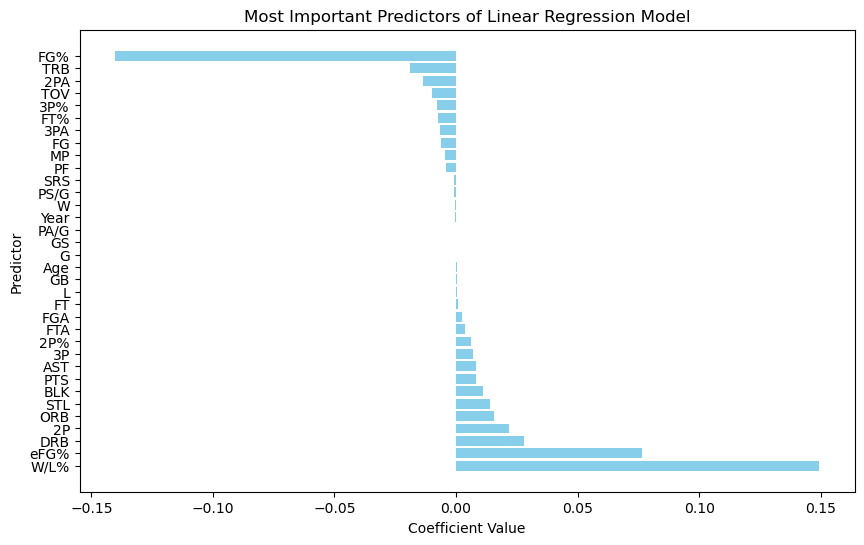

In [197]:
import matplotlib.pyplot as plt
coef_and_predictors = pd.DataFrame(data).sort_values(0, ascending=False)

# Separate coefficients and predictors
coefficients = coef_and_predictors[0]
predictors = coef_and_predictors[1]

# Set up the figure
plt.figure(figsize=(10, 6))

# Create a bar plot of coefficients
plt.barh(predictors, coefficients, color="skyblue")
plt.xlabel("Coefficient Value")
plt.ylabel("Predictor")
plt.title("Most Important Predictors of Linear Regression Model")
plt.show()

### Adding more predictors to improve the model.

In [198]:
stat_ratios = stats[["PTS", "AST", "STL", "BLK", "3P", "Year"]].groupby("Year").apply(lambda x: x/x.mean())

/var/folders/gw/w91jngyn5jj1gy9xk_4wxqjc0000gn/T/ipykernel_1176/2022889540.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  stat_ratios = stats[["PTS", "AST", "STL", "BLK", "3P", "Year"]].groupby("Year").apply(lambda x: x/x.mean())


In [199]:
stat_ratios

,PTS,AST,STL,BLK,3P,Year
0,0.674727,0.313068,0.778905,1.341719,0.00,1.0
1,1.623563,0.983927,1.427992,0.447240,3.84,1.0
2,2.108523,1.207547,1.427992,2.236198,0.00,1.0
3,0.421705,0.000000,0.000000,0.000000,0.00,1.0
4,2.466972,1.565339,1.038540,3.577918,0.00,1.0
...,...,...,...,...,...,...
18240,0.669490,2.010657,2.120711,0.419118,0.00,1.0
18241,0.639059,1.283398,1.178173,1.257353,0.00,1.0
18242,0.243451,0.171120,0.235635,1.466912,0.00,1.0
18243,0.284026,0.513359,0.824721,0.000000,0.00,1.0


In [200]:
stats[["PTS_R", "AST_R", "STL_R", "BLK_R", "3P_R"]] = stat_ratios[["PTS", "AST", "STL", "BLK", "3P"]]

In [201]:
predictors = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
        'W', 'L', 'W/L%', 'GB', 'PS/G',
       'PA/G', 'SRS', "PTS_R", "AST_R", "STL_R", "BLK_R", "3P_R"]

In [202]:
mean_ap, aps, all_predictions = backtest(stats, reg, years[10:], predictors)

In [203]:
mean_ap

0.7713168311167483

**Not a huge improvement by adding predictors.**

In [204]:
stats["NPos"] = stats["Pos"].astype("category").cat.codes
stats["NTm"] = stats["Tm"].astype("category").cat.codes

### Random Forest Regression Model.

In [205]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100,random_state=1, min_samples_split=5)

mean_ap, aps, all_predictions = backtest(stats, rf, years[30:], predictors)

In [206]:
mean_ap

0.7767757242757243

In [207]:
mean_ap, aps, all_predictions = backtest(stats, reg, years[30:], predictors)

In [208]:
mean_ap

0.7869919198102221

**Random Forest Regression works better than Ridge Regression Model.**